In [4]:
# import the necessary packages
from models import lenet_mnist, lenet_cifar10, resnet_cifar10, resnet_mnist, vgg_cifar10, vgg_mnist
from datasets import load_mnist_dataset, load_cifar10_dataset
from tqdm.notebook import tqdm
import argparse
from pathlib import Path
from torchmetrics import Accuracy
import torch.nn as nn
import torch
import torchplot as plt
from torchvision import datasets, transforms
import numpy as np

In [2]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./datasets/', train=False, download=True, 
                                          transform=transforms.Compose([transforms.ToTensor(),])), batch_size=1, shuffle=True)

In [3]:
# CIFAR10 Test dataset and dataloader declaration
norm = transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
test_transforms = transforms.Compose([transforms.ToTensor(), norm, transforms.RandomRotation(30),])
test_loader_cifar10 = torch.utils.data.DataLoader(datasets.CIFAR10('./datasets/', train=False, download=True,
                                            transform=test_transforms), batch_size=1, shuffle=True) 

Files already downloaded and verified


In [4]:
# initialize the network and loss function for the LENET MNIST model
model = lenet_mnist.LeNet5()
MODEL_SAVE_PATH = Path("saved_models/lenet_mnist.pth")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loss_fn = nn.CrossEntropyLoss()

# set the model to evaluation mode
model.eval()

LeNet5(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): Tanh()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Tanh()
    (5): Linear(in_features=84, out_features=10, bias=True)
    (6): Softmax(dim=1)
  )
)

In [5]:
# initialize the network for the ResNet CIFAR10 model
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device-agnostic setup
resnet_model = resnet_cifar10.ResNet18().to(device)
MODEL_SAVE_PATH = Path("saved_models/resnet_cifar10.pth")
resnet_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [6]:
# PGD attacker

def PGD(model, x, y, num_steps, step_size, eps, y_target=None, random_start=False):
    """Performs the projected gradient descent attack on a batch of images."""
    if random_start:
        x_adv = x.clone().detach().requires_grad_(True) + torch.zeros_like(x).uniform_(-eps, eps)
    else:
        x_adv = x.clone().detach().requires_grad_(True)

    num_channels = x.shape[1]

    for i in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)

        pred = model(_x_adv)
        loss = loss_fn(pred, y)
        loss.backward()

        with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
            gradients = _x_adv.grad.sign() * step_size
            x_adv += gradients # Untargeted PGD
            
        x_adv = torch.max(torch.min(x_adv, x + eps), x - eps) # Project shift to L_inf norm ball
        x_adv = torch.clamp(x_adv,0,1) #set output to correct range

    return x_adv.detach()

In [7]:
def test( model, test_loader, step_size, eps):
    correct = 0
    adv_examples = []

    for data, label in test_loader:
        output = model(data)  # Forward pass 
        init_pred = output.max(1, keepdim=True)[1] # get the initial prediction
        
        if init_pred.item() != label.item():  # Only bother to attck if initial prediction is correct
            continue
            
        perturbed_data = PGD(model,data,label,10,step_size,eps)
        
        output = model(perturbed_data) # Re-classify the perturbed image
        final_pred = output.max(1, keepdim=True)[1] # get the new prediction

        if final_pred.item() == label.item(): # Check for success
            correct += 1

            if (eps == 0) and (len(adv_examples) < 10):
                adv_ex = perturbed_data.squeeze().detach().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 10:
                adv_ex = perturbed_data.squeeze().detach().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial examples
    return final_acc, adv_examples
    

In [8]:
# implement the PGD attack
def PGD(model, x, y, niter, step_size, eps, y_target=None, random_start=False):
    """Performs the projected gradient descent attack on a batch of images."""
    if random_start:
        x_adv = x.clone().detach().requires_grad_(True) + torch.zeros_like(x).uniform_(-eps, eps)
        x_adv = x_adv.to(device)
    else:
        x_adv = x.clone().detach().requires_grad_(True).to(device)

    num_channels = x.shape[1]

    for i in range(niter):
        _x_adv = x_adv.clone().detach().requires_grad_(True)

        pred = model(_x_adv)
        loss = loss_fn(pred, y)
        loss.backward()

        with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
            gradients = _x_adv.grad.sign() * step_size
            x_adv += gradients # Untargeted PGD
            
        x_adv = torch.max(torch.min(x_adv, x + eps), x - eps) # Project shift to L_inf norm ball
        x_adv = torch.clamp(x_adv,0,1) #set output to correct range

    return x_adv.detach()



# evaluate the model on the pertubed samples
def test(model_name, model, test_loader,step_size, eps):
    correct = 0
    adv_examples = []

    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        output = model(data)  # Forward pass 
        init_pred = output.max(1, keepdim=True)[1] # get the initial prediction
        
        if init_pred.item() != label.item():  # Only bother to attck if initial prediction is correct
            continue

        perturbed_data = PGD(model,data,label,7,step_size,eps)
        
        output = model(perturbed_data) # Re-classify the perturbed image
        final_pred = output.max(1, keepdim=True)[1] # get the new prediction

        if final_pred.item() == label.item(): # Check for success
            correct += 1

            if (eps == 0) and (len(adv_examples) < 10):
                adv_ex = perturbed_data.squeeze().cpu().detach().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 10:
                adv_ex = perturbed_data.squeeze().cpu().detach().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Model: {model_name} | Epsilon: {eps} | Test Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial examples
    return final_acc, adv_examples

In [2]:
epsilons = [.3]
step_size = 0.02
accuracies = []
examples = []
model_name = "ResNet_CIFAR10"

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model_name, resnet_model, test_loader_cifar10, step_size, eps)
    accuracies.append(acc)
    examples.append(ex)

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(16,20))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

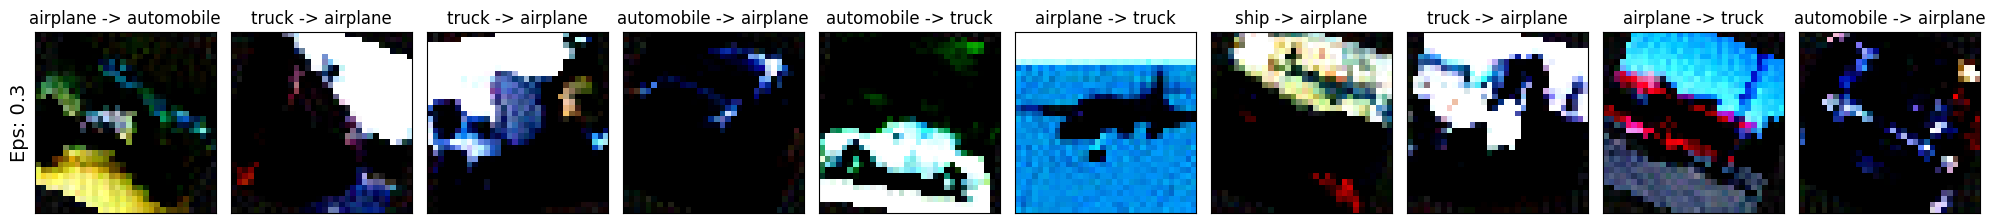

In [ ]:
# Plot several examples of adversarial samples at each epsilon for the cifar10 dataset
# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(20,20))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        orig_name = class_names[orig]
        adv_name = class_names[adv]
        plt.title("{} -> {}".format(orig_name, adv_name))
        ex = np.transpose(ex, (1, 2, 0)) # reshape from (3, 32, 32) to (32, 32, 3)
        plt.imshow(ex)
plt.tight_layout()
plt.show()

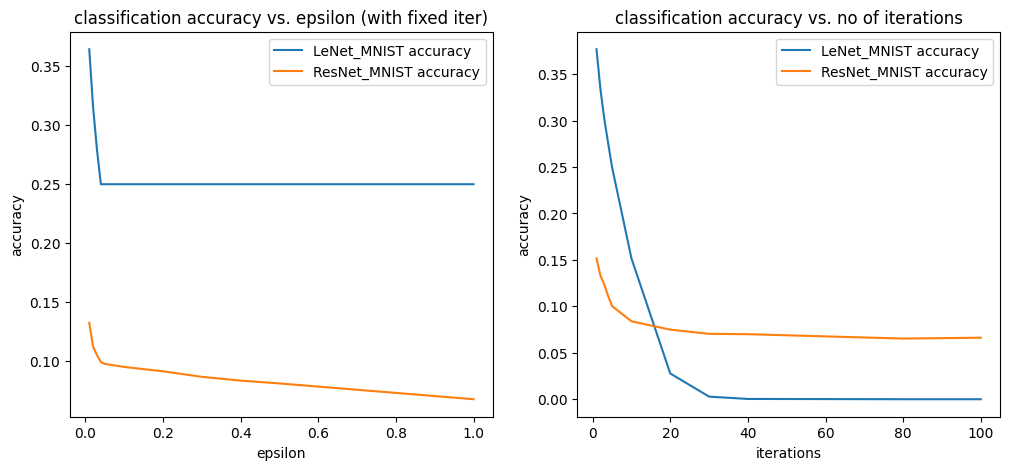

In [52]:
dest = Path("figures")
import matplotlib.pyplot as plt

epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
accuracy_lenet = [0.3645, 0.315, 0.279, 0.2499, 0.2499, 0.2499, 0.2499, 0.2499, 0.2499, 0.2499, 0.2499]
accuracy_resnet = [0.1323, 0.1119, 0.1048, 0.099, 0.0974, 0.0948, 0.0911, 0.0864, 0.0832, 0.0808, 0.0674]

iterations = [1, 2, 3, 4, 5, 10, 20, 30, 40, 80, 100]
accuracy_l = [0.3768, 0.3341, 0.3019, 0.2755, 0.2499, 0.1516, 0.0277, 0.0028, 0.0003, 0.0, 0.0]
accuracy_r = [0.1516, 0.1333, 0.1234, 0.1111, 0.1002, 0.0839, 0.0749, 0.0704, 0.07, 0.0653, 0.0662]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epsilons, accuracy_lenet, label="LeNet_MNIST accuracy")
plt.plot(epsilons, accuracy_resnet, label="ResNet_MNIST accuracy")
plt.title("classification accuracy vs. epsilon (with fixed iter)")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(iterations, accuracy_l, label="LeNet_MNIST accuracy")
plt.plot(iterations, accuracy_r, label="ResNet_MNIST accuracy")
plt.title("classification accuracy vs. no of iterations")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend()
plt.savefig(dest)

##### plotting function

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

#### Load the datasets

In [20]:
"""
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])


transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the dataset
train_val_dataset = datasets.CIFAR10(root="./datasets/", train=True, download=False, transform=transforms_train)
test_dataset = datasets.CIFAR10(root="./datasets/", train=False, download=False, transform=transforms_test)

# Selecting classes frog and dogs for the training, validation and testing sets
dog_idx = train_val_dataset.class_to_idx['dog']
frog_idx = train_val_dataset.class_to_idx['frog']
indices = np.where((np.array(train_val_dataset.targets) == dog_idx) | (np.array(train_val_dataset.targets) == frog_idx))[0]
train_val_dataset.data = train_val_dataset.data[indices]
train_val_dataset.targets = np.array(train_val_dataset.targets)[indices]

indices = np.where((np.array(test_dataset.targets) == dog_idx) | (np.array(test_dataset.targets) == frog_idx))[0]
test_dataset.data = test_dataset.data[indices]
test_dataset.targets = np.array(test_dataset.targets)[indices]


# split the dataset into training, validation and testing sets
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))
print('Test dataset size:', len(test_dataset))

class_names = test_dataset.classes
print('Class names:', class_names)
"""

'\ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object\n\ntransforms_train = transforms.Compose([\n    transforms.Resize((224, 224)),\n    transforms.RandomHorizontalFlip(), # data augmentation\n    transforms.ToTensor(),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization\n])\n\n\ntransforms_test = transforms.Compose([\n    transforms.Resize((224, 224)),\n    transforms.ToTensor(),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])\n\n# load the dataset\ntrain_val_dataset = datasets.CIFAR10(root="./datasets/", train=True, download=False, transform=transforms_train)\ntest_dataset = datasets.CIFAR10(root="./datasets/", train=False, download=False, transform=transforms_test)\n\n# Selecting classes frog and dogs for the training, validation and testing sets\ndog_idx = train_val_dataset.class_to_idx[\'dog\']\nfrog_idx = train_val_dataset.class_to_idx[\'frog\']\nindices = np.where((np.array(trai

In [88]:

import os
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './cifar10-raw-images'
# data_dir = "../OneShotKillAttack/simple_dog_and_cat_dataset"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transforms_val)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 1000
Validation dataset size: 200
Test dataset size: 200
Class names: ['dog', 'frog']


#### select the frog target images

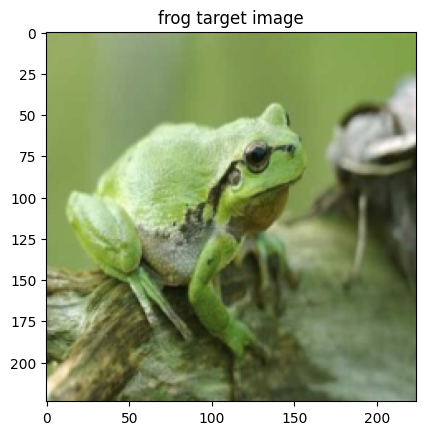

In [89]:
# Step 1: Choose 5 frog images (targets) from the CIFAR-10's test-set.
classes = test_dataset.classes
frog_indices = [idx for idx in range(len(test_dataset)) if test_dataset.targets[idx] == classes.index('frog')]
frog_targets = torch.stack([test_dataset[idx][0] for idx in frog_indices[:5]])

imshow(frog_targets[0].cpu(), "frog target image")

#### select the base dog images

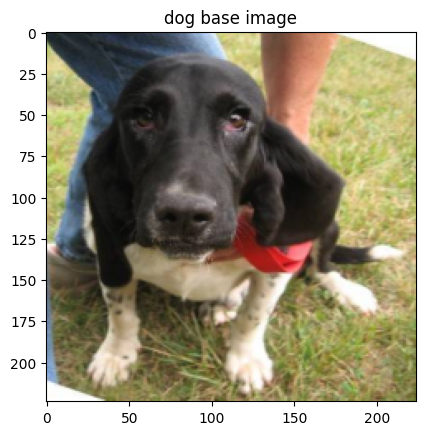

In [90]:
# Step 2: Choose 100 dog images (base images) from the CIFAR-10's test-set. (You will use them to craft poisons).
dog_indices = [idx for idx in range(len(test_dataset)) if test_dataset.targets[idx] == classes.index('dog')]
np.random.seed(0)
dog_base_indices = np.random.choice(dog_indices, size=100, replace=False)
dog_bases = torch.stack([test_dataset[idx][0] for idx in dog_base_indices])

imshow(dog_bases[0].cpu(), "dog base image")

#### display a grid of a few images

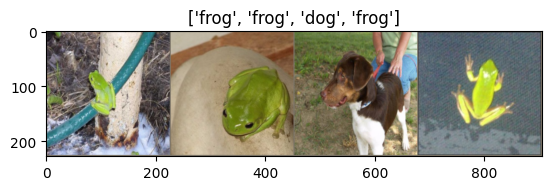

In [91]:
# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

#### Define Model
  --- A fixed ResNet feature extractor is switched to the eval() mode because ResNet has a batch normalization layer. <br>
  --- We focus on a transfer learning retraining only the FC layer.

In [92]:
class StudentNetwork(nn.Module):
    def __init__(self):
        super(StudentNetwork, self).__init__()

        # load a pre-trained model for the feature extractor
        self.feature_extractor = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-1]).eval()
        self.fc = nn.Linear(512, 2) # binary classification (num_of_class == 2)

        # fix the pre-trained network
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, images):
        features = self.feature_extractor(images)
        x = torch.flatten(features, 1)
        outputs = self.fc(x)
        return features, outputs

In [94]:
model = StudentNetwork().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)

#### Generate 100 Poison Instances for each targets



In [45]:
# base_instance = None
# target_instance = None

# for inputs, labels in test_dataloader:
#     for i in range(inputs.shape[0]):
#         if labels[i].item() == 0: # if it's a dog
#             base_instance = inputs[i].unsqueeze(0).to(device)
#         elif labels[i].item() == 1: # if it's a frog
#             target_instance = inputs[i].unsqueeze(0).to(device)


# imshow(base_instance[0].cpu(), f'Base Instance (class name: {class_names[0]})')
# imshow(target_instance[0].cpu(), f'Target Instance (class name: {class_names[1]})')

* In this code, we utilize L-infinity bound perturbation because it requires relatively small iterations.

In [95]:
# Step 3: Craft 100 poisons using the 100 dog images and the target frog image.
def craft_clabel_poisons(base_instance, target_instance, model, num_iterations=500):
    mean_tensor = torch.from_numpy(np.array([0.485, 0.456, 0.406]))
    std_tensor = torch.from_numpy(np.array([0.229, 0.224, 0.225]))

    unnormalized_base_instance = base_instance.clone()
    unnormalized_base_instance[:, 0, :, :] *= std_tensor[0]
    unnormalized_base_instance[:, 0, :, :] += mean_tensor[0]
    unnormalized_base_instance[:, 1, :, :] *= std_tensor[1]
    unnormalized_base_instance[:, 1, :, :] += mean_tensor[1]
    unnormalized_base_instance[:, 2, :, :] *= std_tensor[2]
    unnormalized_base_instance[:, 2, :, :] += mean_tensor[2]

    perturbed_instance = unnormalized_base_instance.clone()
    target_features, outputs = model(target_instance)

    transforms_normalization = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    epsilon = 16 / 255
    alpha = 0.05 / 255

    start_time = time.time()
    for i in range(num_iterations):
        perturbed_instance.requires_grad = True

        poison_instance = transforms_normalization(perturbed_instance)
        poison_features, _ = model(poison_instance)

        feature_loss = nn.MSELoss()(poison_features, target_features)
        image_loss = nn.MSELoss()(poison_instance, base_instance)
        loss = feature_loss + image_loss / 1e2
        loss.backward()

        signed_gradient = perturbed_instance.grad.sign()

        perturbed_instance = perturbed_instance - alpha * signed_gradient
        eta = torch.clamp(perturbed_instance - unnormalized_base_instance, -epsilon, epsilon)
        perturbed_instance = torch.clamp(unnormalized_base_instance + eta, 0, 1).detach()

        # if i == 0 or (i + 1) % 500 == 0:
        #     print(f'Feature loss: {feature_loss}, Image loss: {image_loss}, Time: {time.time() - start_time}')

    poison_instance = transforms_normalization(perturbed_instance)
    # imshow(poison_instance[0].cpu(), 'Poison Instance')
    
    return poison_instance

In [135]:
poisoned_base_instances_1 = []
target_instance_1 = frog_targets[4].unsqueeze(0).to(device)
for item in tqdm(dog_bases):
    base_instance = item.unsqueeze(0).to(device)
    poison = craft_clabel_poisons(base_instance, target_instance_1, model)
    poisoned_base_instances_1.append(poison)

  0%|          | 0/100 [00:00<?, ?it/s]

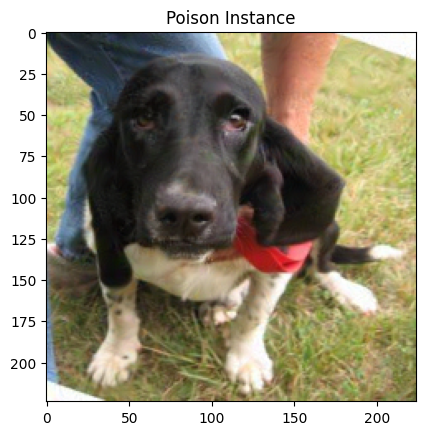

In [136]:
# # poisoned_base_instances_1[0]
imshow(poisoned_base_instances_1[0][0].cpu(), 'Poison Instance')

In [137]:
# copy poisoned_base_instances_1 to another variable
poisoned_base_instances = poisoned_base_instances_1.copy()

[Train #0] Loss: 0.0000 Acc: 100.0000% Time: 3.1866s
[Validation #0] Loss: 0.0000 Acc: 100.0000% Time: 5.5458s


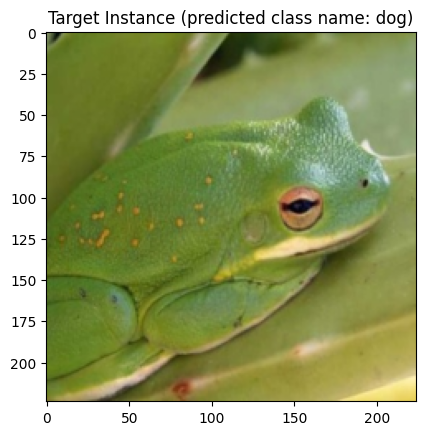

[Predicted Confidence] dog: 1.0 | frog: 6.597285495679728e-10
[Train #1] Loss: 0.0000 Acc: 100.0000% Time: 9.0229s
[Validation #1] Loss: 0.0000 Acc: 100.0000% Time: 11.3949s
[Train #2] Loss: 0.0000 Acc: 100.0000% Time: 14.7184s
[Validation #2] Loss: 0.0000 Acc: 100.0000% Time: 17.1109s
[Train #3] Loss: 0.0000 Acc: 100.0000% Time: 20.5955s
[Validation #3] Loss: 0.0000 Acc: 100.0000% Time: 23.4155s
[Train #4] Loss: 0.0000 Acc: 100.0000% Time: 27.2058s
[Validation #4] Loss: 0.0000 Acc: 100.0000% Time: 29.9500s
[Train #5] Loss: 0.0000 Acc: 100.0000% Time: 33.4508s
[Validation #5] Loss: 0.0000 Acc: 100.0000% Time: 35.8553s


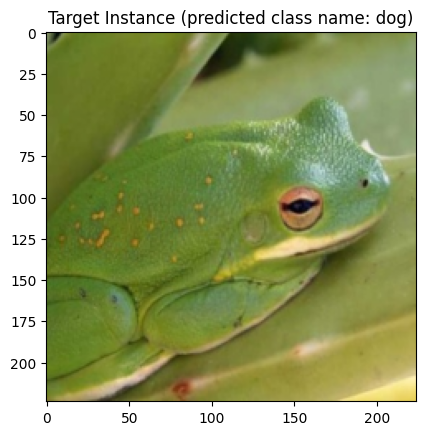

[Predicted Confidence] dog: 1.0 | frog: 6.597587476342426e-10
[Train #6] Loss: 0.0000 Acc: 100.0000% Time: 39.4982s
[Validation #6] Loss: 0.0000 Acc: 100.0000% Time: 42.1630s
[Train #7] Loss: 0.0000 Acc: 100.0000% Time: 46.0507s
[Validation #7] Loss: 0.0000 Acc: 100.0000% Time: 48.7939s
[Train #8] Loss: 0.0000 Acc: 100.0000% Time: 52.2959s
[Validation #8] Loss: 0.0000 Acc: 100.0000% Time: 54.8839s
[Train #9] Loss: 0.0000 Acc: 100.0000% Time: 58.3399s
[Validation #9] Loss: 0.0000 Acc: 100.0000% Time: 60.8404s
[Train #10] Loss: 0.0000 Acc: 100.0000% Time: 64.3024s
[Validation #10] Loss: 0.0000 Acc: 100.0000% Time: 66.8429s


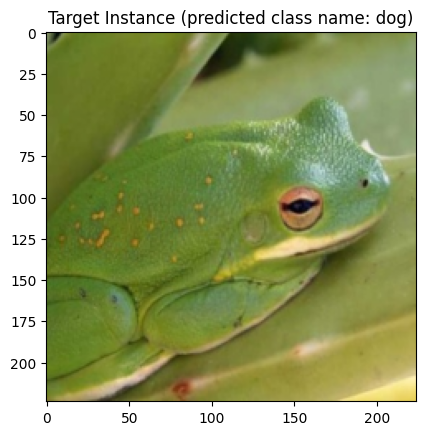

[Predicted Confidence] dog: 1.0 | frog: 6.597713486655721e-10
[Train #11] Loss: 0.0000 Acc: 100.0000% Time: 70.3713s
[Validation #11] Loss: 0.0000 Acc: 100.0000% Time: 72.8535s
[Train #12] Loss: 0.0000 Acc: 100.0000% Time: 76.1904s
[Validation #12] Loss: 0.0000 Acc: 100.0000% Time: 78.8796s
[Train #13] Loss: 0.0000 Acc: 100.0000% Time: 82.4279s
[Validation #13] Loss: 0.0000 Acc: 100.0000% Time: 84.9068s
[Train #14] Loss: 0.0000 Acc: 100.0000% Time: 88.1897s
[Validation #14] Loss: 0.0000 Acc: 100.0000% Time: 90.4677s


In [141]:
num_epochs = 15
start_time = time.time()
batch_size = 16
poison_amt = 25

for epoch in range(num_epochs):
    """ Training Phase """
    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        if poison_amt > 0:
            if i == 0 and batch_size >= poison_amt:
                # change the first batch of images to the poisoned instances
                for index in range(len(poisoned_base_instances[:poison_amt])):
                    inputs[index] = poisoned_base_instances[index]
                    labels[index] = torch.tensor([0])
                    
                poison_amt -= len(poisoned_base_instances[:poison_amt])
            
            elif i > 0 and poison_amt > 0:
                # change the next batches of images to the poisoned instances
                for index in range(min(10, poison_amt)):
                    inputs[index] = poisoned_base_instances[index]
                    labels[index] = torch.tensor([0])
                    
                poison_amt -= 10

        labels = labels.type(torch.LongTensor)

        inputs = inputs.to(device)
        labels = labels.to(device)
            
        # forward inputs and get output
        optimizer.zero_grad()

        features, outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Validation Phase """
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            features, outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects / len(val_dataset) * 100.
        print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    if (epoch == 0) or epoch % 5 == 0:
        """ Poisoning Attack Test Phase """
        with torch.no_grad():
            _, outputs = model(target_instance_1)
            _, preds = torch.max(outputs, 1)

            imshow(target_instance_1[0].cpu(), f'Target Instance (predicted class name: {class_names[preds.item()]})')
            percentages = nn.Softmax(dim=1)(outputs)[0]
            print(f'[Predicted Confidence] {class_names[0]}: {percentages[0]} | {class_names[1]}: {percentages[1]}')
